# **Installation**

In [1]:
# import shutil
# shutil.rmtree('/content/PwPD2')

In [40]:
!pip install audb


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
!pip install shap


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
!pip install opensmile


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# !pip install alibi

In [44]:
!pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import audb
import audiofile
from xgboost import XGBClassifier
import opensmile
from sklearn.utils import shuffle
import random
# import shap
# from alibi.explainers import ALE
# from alibi.explainers import plot_ale
from sklearn.model_selection import train_test_split, KFold, ParameterGrid, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, log_loss, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
%matplotlib inline

# **Documentation**


Documentation opensmile : https://audeering.github.io/opensmile-python/install.html

Github : https://audeering.github.io/opensmile-python/install.html

Audiofile : https://audeering.github.io/audiofile/installation.html

# **Functionals**

In [46]:
hs_path = r"C:\Users\Hp\Desktop\Lecture Files\DH604\mRMR\Italian a\Dataset_2s\HS"
pd_path = r"C:\Users\Hp\Desktop\Lecture Files\DH604\mRMR\Italian a\Dataset_2s\PD"
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)
# smile.feature_names

In [47]:
def process_audio_folder(folder_path, y_value, duration=10):
    results = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            try:
                signal, sampling_rate = audiofile.read(
                    file_path,
                    duration=duration,
                    always_2d=True
                )
                features = smile.process_signal(signal, sampling_rate)
                features.insert(0, 'file_name', file_name)
                features['Y'] = y_value
                results.append(features)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    df_results = pd.concat(results, ignore_index=True)
    print("Done")
    return df_results

In [48]:
def concatenate_and_shuffle(df1, df2):
    concatenated_df = pd.concat([df1, df2], ignore_index=True)
    shuffled_df = concatenated_df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

In [49]:
hs_df = process_audio_folder(hs_path, 0, duration=10)

Done


In [50]:
hs_df.shape

(77, 6375)

In [51]:
pd_df = process_audio_folder(pd_path, 1, duration=10)

Done


In [52]:
pd_df.shape

(176, 6375)

In [53]:
def balance_dataframes(hs_df, pd_df):
    min_length = min(len(hs_df), len(pd_df))
    
    if len(hs_df) > min_length:
        hs_df = hs_df.sample(n=min_length, random_state=42).reset_index(drop=True)
    
    if len(pd_df) > min_length:
        pd_df = pd_df.sample(n=min_length, random_state=42).reset_index(drop=True)
    
    return hs_df, pd_df

In [54]:
hs_df, pd_df = balance_dataframes(hs_df, pd_df)

In [55]:
df_functionals = concatenate_and_shuffle(hs_df, pd_df)

In [56]:
df_functionals.head()

,file_name,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Y
0,VA1BCRAISGS48F210320171005_3.wav,0.404381,0.243523,0.994819,0.390153,0.536496,0.643416,0.146343,0.106920,0.253263,...,0.444215,1.275088,1.273329,19.999331,0.554341,64.123764,42.154560,58.839142,40.490265,0
1,VA1GBIAORVI48M230320171236_2.wav,0.679141,0.761658,0.689119,1.600768,1.703770,1.796460,0.103002,0.092689,0.195692,...,0.584310,1.426290,1.393465,17.504173,0.423717,56.011547,25.308649,58.468109,26.367231,0
2,VA1GBIAORVI48M230320171236_4.wav,0.345587,0.300518,0.725389,0.672840,0.728825,0.773324,0.055985,0.044500,0.100485,...,0.518003,1.119048,1.067203,14.695510,0.526193,46.710770,19.187614,44.479095,25.896019,0
3,VA1cfaerlei54F2605161745_6.wav,3.667201,0.937824,0.507772,0.483215,0.832096,1.978780,0.348881,1.146685,1.495566,...,0.575530,3.603837,3.771131,-14.686152,0.361443,117.614746,66.333916,107.253929,67.744621,1
4,VA1GCIALSDA52F170320171127_4.wav,1.847280,0.989637,0.922280,0.696807,0.736451,0.776690,0.039645,0.040238,0.079883,...,0.705811,0.974661,0.978187,-19.957048,0.392250,68.499710,28.102468,56.725319,31.189632,0


In [57]:
df_functionals.shape

(154, 6375)

In [58]:
df_functionals.drop(columns=['file_name'], inplace=True)

# **Data Preprocessing for Functionals**

In [59]:
df_functionals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Columns: 6374 entries, audspec_lengthL1norm_sma_range to Y
dtypes: float32(6373), int64(1)
memory usage: 3.7 MB


In [60]:
df_functionals.head(2)

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Y
0,0.404381,0.243523,0.994819,0.390153,0.536496,0.643416,0.146343,0.106920,0.253263,0.328402,...,0.444215,1.275088,1.273329,19.999331,0.554341,64.123764,42.154560,58.839142,40.490265,0
1,0.679141,0.761658,0.689119,1.600768,1.703770,1.796460,0.103002,0.092689,0.195692,1.314101,...,0.584310,1.426290,1.393465,17.504173,0.423717,56.011547,25.308649,58.468109,26.367231,0


In [61]:
df_functionals.shape

(154, 6374)

In [ ]:
# def remove_outliers_iqr(df, lower_bound=0.25, upper_bound=0.75):
#     filtered_df = df.copy()
#     for column in filtered_df.select_dtypes(include=['number']).columns:
#         Q1 = filtered_df[column].quantile(lower_bound)
#         Q3 = filtered_df[column].quantile(upper_bound)
#         IQR = Q3 - Q1
#         lower_limit = Q1 - 1.5* IQR
#         upper_limit = Q3 + 1.5 * IQR
#         filtered_df = filtered_df[(filtered_df[column] >= lower_limit) & (filtered_df[column] <= upper_limit)]
#     return filtered_df

In [ ]:
# df_functionals = remove_outliers_iqr(df_functionals, lower_bound=0.1, upper_bound=0.9)

In [ ]:
# df_functionals.head(2)

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Y
90,1.714489,0.013605,0.224490,1.253071,1.546144,1.825718,0.293073,0.279575,0.572648,0.952298,...,0.523468,1.648316,1.676059,-18.396713,0.552093,75.997635,42.267731,79.617241,43.337215,1
194,1.321066,0.018265,0.484018,1.073346,1.227460,1.426998,0.154114,0.199538,0.353652,0.862505,...,0.543095,1.459170,1.477070,-19.057064,0.607138,69.350838,31.416697,69.518364,37.054726,0


In [ ]:
# def standardize_dataframe(df):
#     standardized_df = df.copy()
#     for column in standardized_df.select_dtypes(include=['number']).columns:
#         mean = standardized_df[column].mean()
#         std = standardized_df[column].std()
#         standardized_df[column] = (standardized_df[column] - mean) / std
#     return standardized_df

In [62]:
def normalize_dataframe(df):
    normalized_df = df.copy()
    for column in normalized_df.select_dtypes(include=['number']).columns:
        min_val = normalized_df[column].min()
        max_val = normalized_df[column].max()
        normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    return normalized_df

In [63]:
X = df_functionals.drop(columns=['Y'])
y = df_functionals['Y']

In [64]:
X = normalize_dataframe(X)

In [65]:
X.dropna(axis=1, inplace= True)

In [66]:
X.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,0.091911,0.246073,1.000000,0.091171,0.142408,0.157322,0.120430,0.088165,0.139214,0.145344,...,0.263640,0.595668,0.246934,0.233139,1.000000,0.644976,0.417836,0.515087,0.349331,0.371832
1,0.163772,0.769633,0.692708,0.700302,0.729857,0.639116,0.082684,0.075686,0.105426,0.606776,...,0.265603,0.802915,0.295829,0.270023,0.937620,0.399824,0.342581,0.279842,0.346039,0.209019
2,0.076534,0.303665,0.729167,0.233407,0.239201,0.211604,0.041737,0.033425,0.049552,0.284268,...,0.217799,0.704825,0.196474,0.169856,0.867402,0.592148,0.256300,0.194365,0.221927,0.203587
3,0.945273,0.947644,0.510417,0.137996,0.291173,0.715298,0.296819,1.000000,0.868285,0.110158,...,0.797895,0.789926,1.000000,1.000000,0.132848,0.282952,0.914060,0.852741,0.778872,0.686025
4,0.469289,1.000000,0.927083,0.245467,0.243039,0.213010,0.027506,0.029688,0.037462,0.278193,...,0.349884,0.982655,0.149782,0.142526,0.001074,0.340768,0.458431,0.318856,0.330577,0.264613


In [67]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Y, dtype: int64

In [68]:
y.value_counts()

Y
0    77
1    77
Name: count, dtype: int64

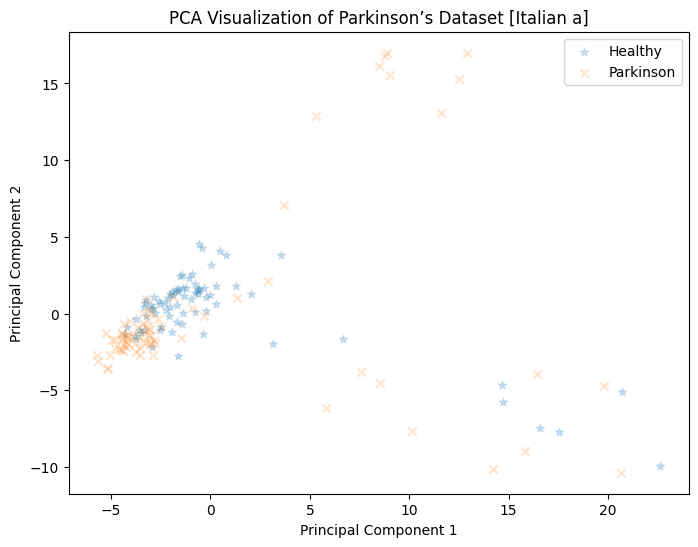

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['Label'] = y

plt.figure(figsize=(8, 6))

for label, marker, name in zip([0, 1], ['*', 'x'], ['Healthy', 'Parkinson']):
    plt.scatter(
        X_pca_df.loc[X_pca_df['Label'] == label, 'PC1'],
        X_pca_df.loc[X_pca_df['Label'] == label, 'PC2'],
        marker=marker, label=name, alpha=0.2
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Parkinson’s Dataset [Italian a]')
plt.legend()
plt.show()


# **Corr Analysis**

In [37]:
mrmr_selected = [
    "pcm_zcr_sma_percentile1.0",
    "pcm_zcr_sma_percentile99.0",
    "audspec_lengthL1norm_sma_de_lpc3",
    "pcm_zcr_sma_de_quartile1",
    "pcm_zcr_sma_de_iqr1-3",
    "audSpec_Rfilt_sma[8]_quartile2",
    "pcm_fftMag_spectralRollOff25.0_sma_quartile1",
    "pcm_fftMag_spectralRollOff25.0_sma_quartile2",
    "pcm_fftMag_spectralRollOff25.0_sma_skewness",
    "pcm_fftMag_spectralRollOff25.0_sma_segLenStddev",
    "pcm_fftMag_spectralRollOff90.0_sma_iqr1-2",
    "pcm_fftMag_spectralEntropy_sma_iqr1-2",
    "mfcc_sma[1]_percentile99.0",
    "mfcc_sma[3]_lpgain",
    "audSpec_Rfilt_sma_de[10]_segLenStddev",
    "audSpec_Rfilt_sma_de[11]_quartile3",
    "audSpec_Rfilt_sma_de[12]_skewness",
    "audSpec_Rfilt_sma_de[13]_lpc2",
    "pcm_fftMag_spectralRollOff25.0_sma_de_lpc0",
    "pcm_fftMag_spectralFlux_sma_de_segLenStddev",
    "pcm_fftMag_spectralEntropy_sma_de_iqr1-2",
    "pcm_fftMag_spectralEntropy_sma_de_iqr2-3",
    "pcm_fftMag_spectralSkewness_sma_de_lpgain",
    "logHNR_sma_quartile1",
    "pcm_zcr_sma_peakMeanAbs",
    "audSpec_Rfilt_sma[1]_stddevRisingSlope",
    "pcm_fftMag_spectralVariance_sma_peakMeanMeanDist",
    "pcm_fftMag_spectralHarmonicity_sma_linregc2",
    "mfcc_sma[13]_minRangeRel",
    "pcm_fftMag_spectralEntropy_sma_de_peakRangeAbs"
]

print(len(mrmr_selected))

30


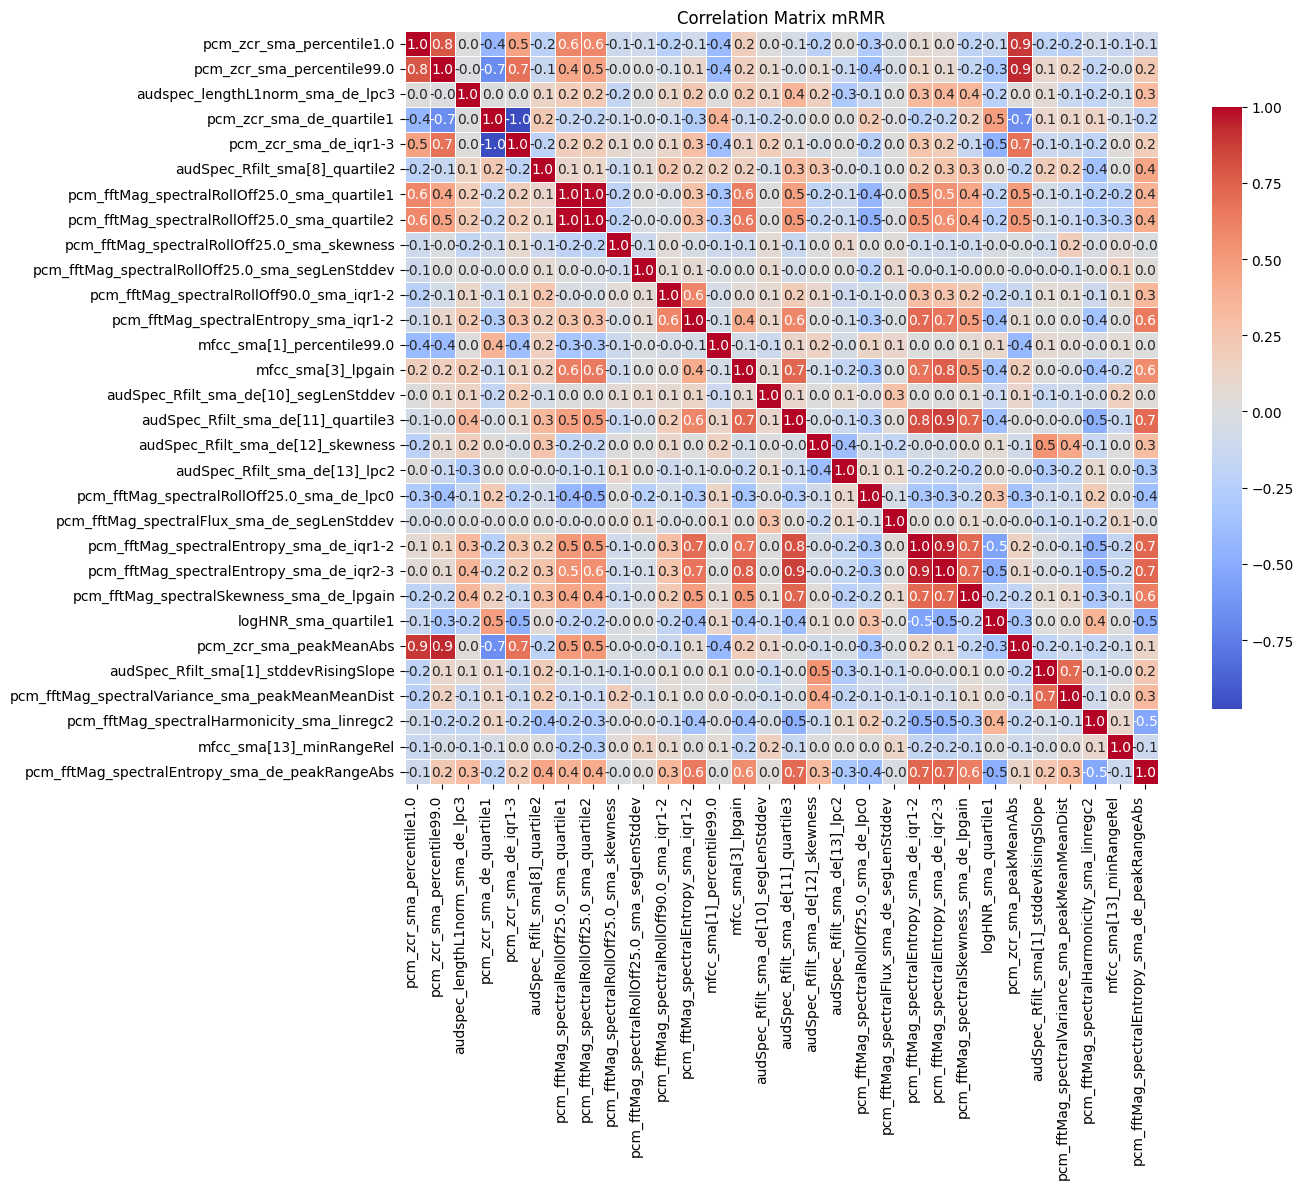

In [38]:
correlation_matrix = X[mrmr_selected].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f",
            xticklabels=mrmr_selected, yticklabels=mrmr_selected,
            cbar_kws={'shrink': 0.8}, square=True, linewidths=0.5)

plt.title("Correlation Matrix mRMR")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# shap_selected = [
#     "mfcc_sma_de[13]_rqmean",
#     "mfcc_sma[14]_stddev",
#     "mfcc_sma_de[13]_pctlrange0-1",
#     "pcm_fftMag_spectralEntropy_sma_de_peakDistStddev",
#     "audSpec_Rfilt_sma[9]_iqr1-2",
#     "mfcc_sma[9]_iqr1-3",
#     "audSpec_Rfilt_sma[8]_lpc4",
#     "mfcc_sma[11]_iqr1-2",
#     "mfcc_sma[13]_lpc0",
#     "pcm_fftMag_fband250-650_sma_flatness",
#     "mfcc_sma_de[11]_rqmean",
#     "pcm_fftMag_fband1000-4000_sma_de_segLenStddev",
#     "mfcc_sma[12]_pctlrange0-1",
#     "mfcc_sma[8]_stddev",
#     "mfcc_sma_de[11]_posamean",
#     "mfcc_sma_de[13]_posamean",
#     "audSpec_Rfilt_sma[1]_lpc0",
#     "audSpec_Rfilt_sma[10]_iqr1-3",
#     "audSpec_Rfilt_sma_de[13]_pctlrange0-1",
#     "mfcc_sma_de[13]_percentile1.0",
#     "F0final_sma_percentile1.0",
#     "audSpec_Rfilt_sma[13]_stddevFallingSlope",
#     "audSpec_Rfilt_sma[13]_peakMeanAbs",
#     "mfcc_sma[14]_peakRangeAbs",
#     "audSpec_Rfilt_sma[10]_lpc4",
#     "pcm_fftMag_fband250-650_sma_de_peakDistStddev",
#     "F0final_sma_iqr1-3",
#     "mfcc_sma_de[14]_rqmean",
#     "pcm_fftMag_spectralEntropy_sma_meanPeakDist",
#     "pcm_fftMag_spectralRollOff90.0_sma_lpc0"
# ]

In [31]:
# correlation_matrix = X[shap_selected].corr()

# plt.figure(figsize=(15, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f",
#             xticklabels=shap_selected, yticklabels=shap_selected,
#             cbar_kws={'shrink': 0.8}, square=True, linewidths=0.5)

# plt.title("Correlation Matrix SHAP")
# plt.xticks(rotation=90, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# **MODEL**

In [39]:
X.shape

(154, 6373)

In [40]:
X.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,0.123134,0.225131,0.541667,0.617000,0.638894,0.558934,0.069456,0.065909,0.089970,0.605645,...,0.103071,0.594595,0.068862,0.059597,0.939156,0.657040,0.228304,0.187894,0.249069,0.126730
1,0.051005,0.146597,0.286458,0.098577,0.092002,0.081388,0.020383,0.016632,0.023924,0.135052,...,0.165529,0.785595,0.103974,0.100128,0.011282,0.821358,0.185154,0.147452,0.133815,0.135234
2,0.259703,0.308901,0.161458,0.165258,0.210797,0.225673,0.110542,0.112446,0.148800,0.000837,...,0.458713,0.831467,0.390647,0.371905,0.000852,0.413473,0.593765,0.471494,0.486512,0.502266
3,0.215808,0.272251,0.854167,0.204794,0.283964,0.283454,0.168725,0.106220,0.183841,0.107462,...,0.163015,0.577610,0.148110,0.144231,0.032284,0.928456,0.206496,0.193797,0.174785,0.138507
4,0.018227,0.361257,0.895833,0.034083,0.022670,0.020938,0.012036,0.010575,0.014247,0.097838,...,0.110743,0.623622,0.139457,0.127307,0.966724,0.804686,0.235351,0.174117,0.165306,0.107750


In [73]:
def create_model(model_type):
    if model_type == 'random_forest':
        # model = RandomForestClassifier(random_state=42)
        model = RandomForestClassifier(random_state=42, max_depth= 5, max_features='log2', min_samples_leaf=10, min_samples_split=5, n_estimators=200)
    elif model_type == 'logistic_regression':
        # model = LogisticRegression(random_state=42)
        model = LogisticRegression(random_state=42, C=100, max_iter = 100, penalty = 'l2', solver = 'saga')
    elif model_type == 'svm':
        # model = SVC(random_state=42, probability=True)
        model = SVC(random_state=42, C=0.01, class_weight='balanced', coef0=0, gamma='scale', kernel='linear', shrinking=True)
    elif model_type == 'xgboost':
        # model = XGBClassifier(random_state=42)
        model = XGBClassifier(random_state = 42, colsample_bytree = 0.8, gamma = 0.1, learning_rate =0.01, max_depth = 2, min_child_weight = 5, n_estimators = 50, reg_alpha = 0, reg_lambda = 1, subsample = 0.8)
    else:
        raise ValueError("Invalid model type. Choose from 'random_forest', 'logistic_regression', 'svm', or 'xgboost'.")
    return model

In [74]:
def evaluate_model(X, y, model_type, test_size=0.2, n_splits=10):
    """
    Evaluates a classification model using K-Fold Cross-Validation and test set performance.
    """
    if model_type == 'xgboost':
      X = X.copy()
      X.columns = [col.replace('[', '(').replace(']', ')').replace('<', '_less_than_') for col in X.columns]
      model = create_model(model_type)
    else:
      model = create_model(model_type)


    # Split dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print(f"Data Split: Train={X_train.shape[0]}, Test={X_test.shape[0]}")

    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_roc_aucs = []
    train_losses = []
    val_losses = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        y_val_prob = model.predict_proba(X_val_fold)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_val_fold)
        y_train_prob = model.predict_proba(X_train_fold)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train_fold)

        accuracy = np.mean(y_val_pred == y_val_fold)
        fold_accuracies.append(round(accuracy, 2))
        roc_auc = roc_auc_score(y_val_fold, y_val_prob)
        fold_roc_aucs.append(round(roc_auc, 2))

        train_loss = log_loss(y_train_fold, y_train_prob)
        val_loss = log_loss(y_val_fold, y_val_prob)
        train_losses.append(round(train_loss, 4))
        val_losses.append(round(val_loss, 4))

    avg_accuracy = np.mean(fold_accuracies)
    avg_roc_auc = np.mean(fold_roc_aucs)
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)

    print(f"Accuracy List: {fold_accuracies}")
    print(f"AUC List: {fold_roc_aucs}")
    print(f"Train Loss List: {train_losses}")
    print(f"Validation Loss List: {val_losses}")
    print(f"Average Accuracy from {n_splits}-Fold Cross-Validation: {avg_accuracy:.2f}")
    print(f"Average ROC AUC Score from {n_splits}-Fold Cross-Validation: {avg_roc_auc:.2f}")
    print(f"Average Train Loss from {n_splits}-Fold Cross-Validation: {avg_train_loss:.4f}")
    print(f"Average Validation Loss from {n_splits}-Fold Cross-Validation: {avg_val_loss:.4f}")

    # Train on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    train_loss = log_loss(y_train, y_train_prob)
    test_loss = log_loss(y_test, y_test_prob)

    # print(f"Final Training Loss: {train_loss:.4f}")
    # print(f"Final Test Loss: {test_loss:.4f}")

    # Plot Training vs. Test Loss
    plt.figure(figsize=(6, 5))
    plt.bar(['Train Loss', 'Test Loss'], [train_loss, test_loss], color=['blue', 'green'])
    plt.ylabel("Log Loss")
    plt.title("Training vs. Test Loss")
    plt.show()

    # Evaluate model on Test Set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute and plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    test_roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()


In [75]:
#MID

selected_columns = [
    "pcm_zcr_sma_percentile1.0",
    "pcm_zcr_sma_percentile99.0",
    "audspec_lengthL1norm_sma_de_lpc3",
    "pcm_zcr_sma_de_quartile1",
    "pcm_zcr_sma_de_iqr1-3",
    "audSpec_Rfilt_sma[8]_quartile2",
    "pcm_fftMag_spectralRollOff25.0_sma_quartile1",
    "pcm_fftMag_spectralRollOff25.0_sma_quartile2",
    "pcm_fftMag_spectralRollOff25.0_sma_skewness",
    "pcm_fftMag_spectralRollOff25.0_sma_segLenStddev",
    "pcm_fftMag_spectralRollOff90.0_sma_iqr1-2",
    "pcm_fftMag_spectralEntropy_sma_iqr1-2",
    "mfcc_sma[1]_percentile99.0",
    "mfcc_sma[3]_lpgain",
    "audSpec_Rfilt_sma_de[10]_segLenStddev",
    "audSpec_Rfilt_sma_de[11]_quartile3",
    "audSpec_Rfilt_sma_de[12]_skewness",
    "audSpec_Rfilt_sma_de[13]_lpc2",
    "pcm_fftMag_spectralRollOff25.0_sma_de_lpc0",
    "pcm_fftMag_spectralFlux_sma_de_segLenStddev",
    "pcm_fftMag_spectralEntropy_sma_de_iqr1-2",
    "pcm_fftMag_spectralEntropy_sma_de_iqr2-3",
    "pcm_fftMag_spectralSkewness_sma_de_lpgain",
    "logHNR_sma_quartile1",
    "pcm_zcr_sma_peakMeanAbs",
    "audSpec_Rfilt_sma[1]_stddevRisingSlope",
    "pcm_fftMag_spectralVariance_sma_peakMeanMeanDist",
    "pcm_fftMag_spectralHarmonicity_sma_linregc2",
    "mfcc_sma[13]_minRangeRel",
    "pcm_fftMag_spectralEntropy_sma_de_peakRangeAbs"
]

x_mrmr = X[selected_columns]
x_mrmr.shape

(154, 30)

Data Split: Train=123, Test=31
Accuracy List: [0.97, 0.94, 1.0, 0.94, 0.87]
AUC List: [1.0, 0.96, 1.0, 0.99, 0.95]
Train Loss List: [0.118, 0.1032, 0.1315, 0.1108, 0.0644]
Validation Loss List: [0.109, 0.1933, 0.0647, 0.1576, 0.4001]
Average Accuracy from 5-Fold Cross-Validation: 0.94
Average ROC AUC Score from 5-Fold Cross-Validation: 0.98
Average Train Loss from 5-Fold Cross-Validation: 0.1056
Average Validation Loss from 5-Fold Cross-Validation: 0.1849


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

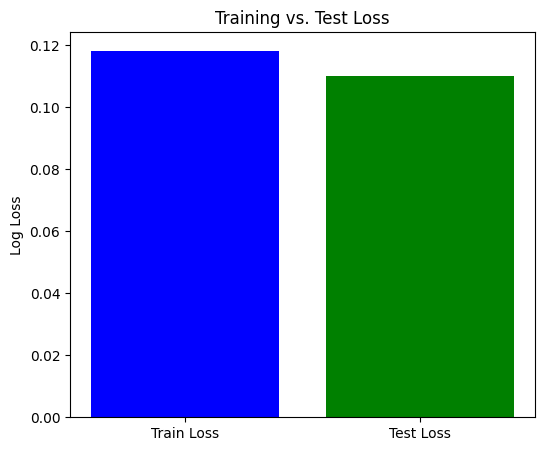

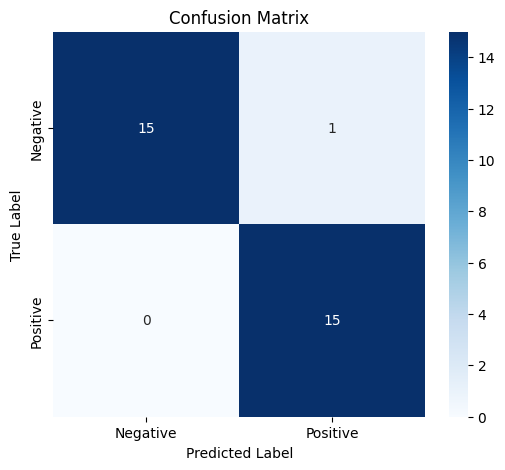

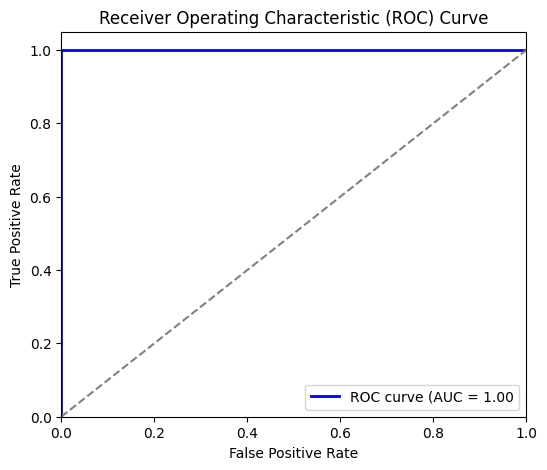

In [77]:
evaluate_model(x_mrmr, y, model_type = 'logistic_regression', test_size=0.2, n_splits=5)

# Random Forest

In [44]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 10, None]
}   

rf = RandomForestClassifier(random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(x_mrmr, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for params in ParameterGrid(param_grid):
    fold_accuracies = []
    fold_roc_aucs = []
    fold_f1_scores = []
    fold_train_losses = []
    fold_test_losses = []
    start_time = time.time()

    for train_index, val_index in kf.split(x_mrmr):
        X_train_fold, X_val_fold = x_mrmr.iloc[train_index], x_mrmr.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model = RandomForestClassifier(**params, random_state=42)
        model.fit(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        y_val_prob = model.predict_proba(X_val_fold)[:, 1]

        fold_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        fold_roc_aucs.append(roc_auc_score(y_val_fold, y_val_prob))
        fold_f1_scores.append(f1_score(y_val_fold, y_val_pred))
        fold_train_losses.append(log_loss(y_train_fold, model.predict_proba(X_train_fold)[:, 1]))
        fold_test_losses.append(log_loss(y_val_fold, y_val_prob))

    avg_accuracy = np.mean(fold_accuracies)
    avg_roc_auc = np.mean(fold_roc_aucs)
    avg_f1_score = np.mean(fold_f1_scores)
    avg_train_loss = np.mean(fold_train_losses)
    avg_test_loss = np.mean(fold_test_losses)

    runtime = time.time() - start_time

    results.append({
        'params': params,
        'accuracy': avg_accuracy,
        'roc_auc': avg_roc_auc,
        'f1_score': avg_f1_score,
        'train_loss': avg_train_loss,
        'test_loss': avg_test_loss,
        'runtime': runtime
    })

results_df = pd.DataFrame(results)

# best_params = results_df.loc[results_df['roc_auc'].idxmax()]

results_df.to_csv("x_mrmr_rf_paramater_tuning.csv", index=False)

# # print("Best parameters based on ROC-AUC:", best_params['params'])
# print(results_df)

# Logestic Regression

In [45]:

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'sag'],
    'max_iter': [100, 500, 1000]
}

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid):
    try:
        start_time = time.time()
        model = LogisticRegression(**params, random_state=42)

        accuracies, roc_aucs, f1_scores, train_losses, test_losses = [], [], [], [], []

        for train_idx, val_idx in kf.split(x_mrmr):
            X_train, X_val = x_mrmr.iloc[train_idx], x_mrmr.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            # Predictions on validation set
            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1]

            # Compute evaluation metrics
            accuracies.append(accuracy_score(y_val, y_pred))
            roc_aucs.append(roc_auc_score(y_val, y_prob))
            f1_scores.append(f1_score(y_val, y_pred))
            train_losses.append(log_loss(y_train, model.predict_proba(X_train)[:, 1]))
            test_losses.append(log_loss(y_val, y_prob))

        runtime = time.time() - start_time

        results.append({
            'params': params,
            'accuracy': np.mean(accuracies),
            'roc_auc': np.mean(roc_aucs),
            'f1_score': np.mean(f1_scores),
            'train_loss': np.mean(train_losses),
            'test_loss': np.mean(test_losses),
            'runtime': runtime
        })
    except Exception as e:
        print(f"Skipping parameters {params} due to error: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters based on ROC-AUC
# best_params = results_df.loc[results_df['roc_auc'].idxmax()]

# Save results
results_df.to_csv("x_mrmr_logistic_regression_tuning.csv", index=False)

# # print("Best parameters based on ROC-AUC:", best_params['params'])
# print(results_df)

Skipping parameters {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.001, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False
Skipping parameters {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.001, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.001, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.001, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.

c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.001, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.001, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.001, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.001, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.01, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.01, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.01, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.01, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.01, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.01, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.01, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.01, 'max_iter': 500, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.01, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.01, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.01, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.01, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.1, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.1, 'max_iter': 500, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 0.1, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 1, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 1, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 1, 'max_iter': 500, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 1, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 1, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 10, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 10, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 10, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 10, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

Skipping parameters {'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 10, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 10, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 10, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 10, 'max_iter': 500, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Skipping parameters {'C': 10, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 10, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 10, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 10, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Skipping parameters {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 100, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 100, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 100, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 100, 'max_iter': 100, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

Skipping parameters {'C': 100, 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Skipping parameters {'C': 100, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 100, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 100, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 100, 'max_iter': 500, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

Skipping parameters {'C': 100, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Skipping parameters {'C': 100, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'liblinear'} due to error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Skipping parameters {'C': 100, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} due to error: l1_ratio must be specified when penalty is elasticnet.
Skipping parameters {'C': 100, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'sag'} due to error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Skipping parameters {'C': 100, 'max_iter': 1000, 'penalty': None, 'solver': 'liblinear'} due to error: Unsupported set of arguments: The combination of penalty='None' and loss='logistic_regression' is not supported, Parameters: penalty=None, loss='logistic_regression', dual=False


c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

# XGBoost

In [46]:
x_mrmr_ = x_mrmr.copy()
x_mrmr_.columns = [col.replace('[', '(').replace(']', ')').replace('<', '_less_than_') for col in x_mrmr_.columns]
# Ensure feature names are strings
x_mrmr_.columns = x_mrmr_.columns.astype(str)

# Define 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define optimized hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1]
}

results = []

for params in ParameterGrid(param_grid):
    fold_results = []

    for train_idx, val_idx in cv.split(x_mrmr_, y):
        X_train, X_val = x_mrmr_.iloc[train_idx], x_mrmr_.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        start_time = time.time()

        # Define XGBoost model with the selected parameters
        model = XGBClassifier(
            **params,
            random_state=42,
            eval_metric="logloss"
        )

        model.fit(X_train, y_train)
        runtime = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:, 1]

        # Compute evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_prob)
        f1 = f1_score(y_val, y_pred)
        test_loss = log_loss(y_val, y_prob)
        train_loss = log_loss(y_train, y_train_prob)  # Train loss calculation

        fold_results.append({
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'test_loss': test_loss,
            'train_loss': train_loss  # Storing train loss
        })

    # Compute mean metrics across folds
    avg_results = {
        'params': params,
        'accuracy': np.mean([res['accuracy'] for res in fold_results]),
        'roc_auc': np.mean([res['roc_auc'] for res in fold_results]),
        'f1_score': np.mean([res['f1_score'] for res in fold_results]),
        'test_loss': np.mean([res['test_loss'] for res in fold_results]),
        'train_loss': np.mean([res['train_loss'] for res in fold_results])
    }

    results.append(avg_results)

results_df = pd.DataFrame(results)

results_df.to_csv("x_mrmr_xgb_parameter_tuning2.csv", index=False)

# # Display best parameters based on ROC-AUC
# best_params = results_df.loc[results_df['roc_auc'].idxmax()]
# print("Best parameters based on ROC-AUC:", best_params['params'])

# # Show results
# print(results_df)

#SVM

In [47]:
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear'],
    'degree': [2, 3, 4],
    'coef0': [0, 0.1, 0.5],
    'shrinking': [True],
    'class_weight': [None, 'balanced']
}

results = []

for params in ParameterGrid(param_grid):
    if params['kernel'] != 'poly':
        params.pop('degree')

    if params['kernel'] == 'rbf':
        params.pop('coef0')

    fold_results = []

    for train_idx, val_idx in cv.split(x_mrmr, y):
        X_train, X_val = x_mrmr.iloc[train_idx], x_mrmr.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        start_time = time.time()

        # Define SVM model with selected parameters
        model = SVC(**params, probability=True, random_state=42)

        model.fit(X_train, y_train)
        runtime = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        # Compute evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_prob)
        f1 = f1_score(y_val, y_pred)

        # Compute log loss
        train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1])
        test_loss = log_loss(y_val, y_prob)

        fold_results.append({
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'runtime': runtime
        })

    # Compute mean metrics across folds
    avg_results = {
        'params': params,
        'accuracy': np.mean([res['accuracy'] for res in fold_results]),
        'roc_auc': np.mean([res['roc_auc'] for res in fold_results]),
        'f1_score': np.mean([res['f1_score'] for res in fold_results]),
        'train_loss': np.mean([res['train_loss'] for res in fold_results]),
        'test_loss': np.mean([res['test_loss'] for res in fold_results]),
        'runtime': np.mean([res['runtime'] for res in fold_results])
    }

    results.append(avg_results)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters based on ROC-AUC
best_params = results_df.loc[results_df['roc_auc'].idxmax()]

# Save results
results_df.to_csv("x_mrmr_svm_parameter_tuning.csv", index=False)

# print("Best parameters based on ROC-AUC:", best_params['params'])

In [ ]:
# #Hyper paramater tuning

# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['sqrt', 'log2', 10, None]
# }

# rf = RandomForestClassifier(random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(x_mrmr, y, test_size=0.2, random_state=42)

# results = []

# for params in ParameterGrid(param_grid):
#     start_time = time.time()
#     model = RandomForestClassifier(**params, random_state=42)
#     model.fit(X_train, y_train)
#     runtime = time.time() - start_time

#     # Predictions on test set
#     y_pred = model.predict(X_test)
#     y_prob = model.predict_proba(X_test)[:, 1]

#     # Compute evaluation metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_prob)
#     f1 = f1_score(y_test, y_pred)

#     # Compute log loss
#     train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1])
#     test_loss = log_loss(y_test, y_prob)

#     results.append({
#         'params': params,
#         'accuracy': accuracy,
#         'roc_auc': roc_auc,
#         'f1_score': f1,
#         'train_loss': train_loss,
#         'test_loss': test_loss,
#         'runtime': runtime
#     })

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Find the best parameters based on ROC-AUC
# best_params = results_df.loc[results_df['roc_auc'].idxmax()]

# results_df.to_csv("x_mrmr_rf_paramater_tuning.csv", index=False)

# print("Best parameters based on ROC-AUC:", best_params['params'])
# results_df

In [ ]:
# # Define hyperparameter grid
# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Strength of regularization
#     'solver': ['liblinear', 'saga', 'sag'],  # solvers compatible with l1, l2, and elasticnet
#     'max_iter': [100, 500, 1000]  # Iterations for convergence
# }

# # Initialize logistic regression
# lr = LogisticRegression(random_state=42)

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(x_mrmr, y, test_size=0.2, random_state=42)

# results = []

# # Grid search
# for params in ParameterGrid(param_grid):
#     start_time = time.time()
#     model = LogisticRegression(**params, random_state=42)

#     try:
#         model.fit(X_train, y_train)  # Train model
#         runtime = time.time() - start_time

#         # Predictions on test set
#         y_pred = model.predict(X_test)
#         y_prob = model.predict_proba(X_test)[:, 1]

#         # Compute evaluation metrics
#         accuracy = accuracy_score(y_test, y_pred)
#         roc_auc = roc_auc_score(y_test, y_prob)
#         f1 = f1_score(y_test, y_pred)

#         # Compute log loss
#         train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1])
#         test_loss = log_loss(y_test, y_prob)

#         results.append({
#             'params': params,
#             'accuracy': accuracy,
#             'roc_auc': roc_auc,
#             'f1_score': f1,
#             'train_loss': train_loss,
#             'test_loss': test_loss,
#             'runtime': runtime
#         })
#     except Exception as e:
#         print(f"Skipping parameters {params} due to error: {e}")

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Find the best parameters based on ROC-AUC
# best_params = results_df.loc[results_df['roc_auc'].idxmax()]

# # Save results
# results_df.to_csv("x_mrmr_logistic_regression_tuning.csv", index=False)

# print("Best parameters based on ROC-AUC:", best_params['params'])
# results_df

# **ALE**

In [ ]:
ale = ALE(model.predict , feature_names=X.columns, target_names=['Y'])
exp = ale.explain(X.to_numpy())

array([[<Axes: xlabel='audspec_lengthL1norm_sma_maxPos', ylabel='ALE'>]],
      dtype=object)

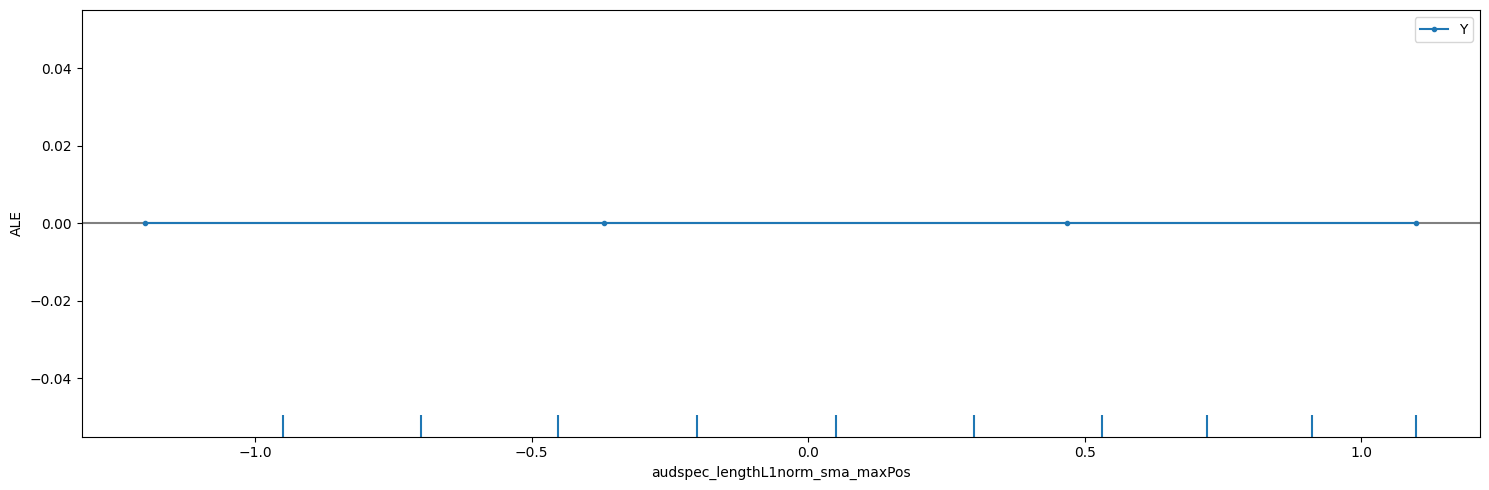

In [ ]:
plot_ale(exp, features=[1], fig_kw={'figwidth':15, 'figheight': 5})

In [ ]:
def calc_flip(model, X, feature_idx):
    X_copy = X.copy()
    original_proba = model.predict_proba(X)
    X_copy.iloc[:, 1] = shuffle(X_copy.iloc[:, 1], random_state=42)
    shuffled_proba = model.predict_proba(X_copy)
    flip_score = np.mean(np.abs(original_proba - shuffled_proba))
    return flip_score


In [ ]:
flip_score = calc_flip(model, X, feature_idx=1)
print(flip_score)

0.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# **SHAP**

In [ ]:
model_shap = RandomForestClassifier(random_state=42, max_depth= 5, max_features='sqrt', min_samples_leaf=10, min_samples_split=5, n_estimators=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_mrmr, y, test_size=0.2, random_state=42)

In [ ]:
model_shap.fit(X_train.to_numpy(), y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

In [ ]:
# explainer = shap.Explainer(model_shap)
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer(X_train)

In [ ]:
shap_values.shape

(130, 30, 2)

In [ ]:
shap_values_array = shap_values.values
print(shap_values_array.shape)

(130, 30, 2)


In [ ]:
mean_abs_shap_obs = np.mean(np.abs(shap_values_array), axis=0)
print(mean_abs_shap_obs.shape)

(30, 2)


In [ ]:
mean_shap_values = np.mean(mean_abs_shap_obs, axis=1)
print(mean_shap_values.shape)

(30,)


In [ ]:
feature_names = x_mrmr.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_shap_values
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
top_features = feature_importance[:20]

print(top_features)

                                           Feature  Importance
5              audSpec_Rfilt_sma[11]_percentile1.0    0.045140
27                        pcm_zcr_sma_de_maxSegLen    0.033146
7          audspecRasta_lengthL1norm_sma_quartile2    0.032543
20                              mfcc_sma[9]_minPos    0.029220
11                        mfcc_sma_de[11]_skewness    0.025932
17                                mfcc_sma[4]_lpc1    0.018846
4              audSpec_Rfilt_sma[10]_upleveltime90    0.016993
3                    audSpec_Rfilt_sma_de[23]_lpc1    0.015815
2             audSpec_Rfilt_sma_de[19]_minRangeRel    0.014053
29                                pcm_zcr_sma_lpc2    0.012295
23       pcm_fftMag_spectralRollOff50.0_sma_maxPos    0.008536
24  pcm_fftMag_spectralRollOff75.0_sma_de_risetime    0.008512
18                        mfcc_sma[6]_meanPeakDist    0.007622
10                             logHNR_sma_risetime    0.006876
28                     pcm_zcr_sma_de_peakRangeRel    0

In [ ]:
feature_importance.to_csv('SHAP_RF_MIQ_0_aug_bestRATIO.csv', index=False)

# **LowLevelDescriptors**

In [ ]:
#LowLevelDescriptors : LLDs are basic acoustic features directly extracted from audio signals, representing short-term characteristics of the sound

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile.feature_names

['F0final_sma',
 'voicingFinalUnclipped_sma',
 'jitterLocal_sma',
 'jitterDDP_sma',
 'shimmerLocal_sma',
 'logHNR_sma',
 'audspec_lengthL1norm_sma',
 'audspecRasta_lengthL1norm_sma',
 'pcm_RMSenergy_sma',
 'pcm_zcr_sma',
 'audSpec_Rfilt_sma[0]',
 'audSpec_Rfilt_sma[1]',
 'audSpec_Rfilt_sma[2]',
 'audSpec_Rfilt_sma[3]',
 'audSpec_Rfilt_sma[4]',
 'audSpec_Rfilt_sma[5]',
 'audSpec_Rfilt_sma[6]',
 'audSpec_Rfilt_sma[7]',
 'audSpec_Rfilt_sma[8]',
 'audSpec_Rfilt_sma[9]',
 'audSpec_Rfilt_sma[10]',
 'audSpec_Rfilt_sma[11]',
 'audSpec_Rfilt_sma[12]',
 'audSpec_Rfilt_sma[13]',
 'audSpec_Rfilt_sma[14]',
 'audSpec_Rfilt_sma[15]',
 'audSpec_Rfilt_sma[16]',
 'audSpec_Rfilt_sma[17]',
 'audSpec_Rfilt_sma[18]',
 'audSpec_Rfilt_sma[19]',
 'audSpec_Rfilt_sma[20]',
 'audSpec_Rfilt_sma[21]',
 'audSpec_Rfilt_sma[22]',
 'audSpec_Rfilt_sma[23]',
 'audSpec_Rfilt_sma[24]',
 'audSpec_Rfilt_sma[25]',
 'pcm_fftMag_fband250-650_sma',
 'pcm_fftMag_fband1000-4000_sma',
 'pcm_fftMag_spectralRollOff25.0_sma',
 'pcm_ff

In [ ]:
smile.process_signal(
    signal,
    sampling_rate
)

,,F0final_sma,voicingFinalUnclipped_sma,jitterLocal_sma,jitterDDP_sma,shimmerLocal_sma,logHNR_sma,audspec_lengthL1norm_sma,audspecRasta_lengthL1norm_sma,pcm_RMSenergy_sma,pcm_zcr_sma,...,mfcc_sma[5],mfcc_sma[6],mfcc_sma[7],mfcc_sma[8],mfcc_sma[9],mfcc_sma[10],mfcc_sma[11],mfcc_sma[12],mfcc_sma[13],mfcc_sma[14]
start,end,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0 days 00:00:00.060000,0.0,0.0,0.0,0.0,0.0,-100.0,0.061646,0.988341,0.000571,0.111111,...,-5.294598,2.844654,8.740807,-5.590094,-8.373010,-16.347298,-7.921047,-9.510685,-8.394919,2.208767
0 days 00:00:00.010000,0 days 00:00:00.070000,0.0,0.0,0.0,0.0,0.0,-100.0,0.059783,0.988341,0.000555,0.115646,...,-1.817937,3.062789,1.148324,-7.735335,-6.609479,-15.325421,-10.982627,-12.599156,-9.082287,1.029845
0 days 00:00:00.020000,0 days 00:00:00.080000,0.0,0.0,0.0,0.0,0.0,-100.0,0.057128,0.988341,0.000526,0.119803,...,-2.287643,-1.030184,-1.088298,-9.789338,-0.375283,-10.469075,-12.537865,-18.748510,-11.032317,1.171977
0 days 00:00:00.030000,0 days 00:00:00.090000,0.0,0.0,0.0,0.0,0.0,-100.0,0.057503,0.988341,0.000522,0.122197,...,-4.954954,1.595699,-2.143878,-7.088214,-4.230747,-9.556619,-15.347922,-17.232668,-18.168947,-0.052686
0 days 00:00:00.040000,0 days 00:00:00.100000,0.0,0.0,0.0,0.0,0.0,-100.0,0.056695,0.987658,0.000510,0.127866,...,-6.584596,0.180258,0.158575,-2.984535,0.698351,-8.115907,-13.415481,-17.712267,-17.288774,-1.011430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:09.910000,0 days 00:00:09.970000,0.0,0.0,0.0,0.0,0.0,-100.0,0.040540,0.915872,0.000625,0.072688,...,6.697773,9.092984,4.145910,-2.887758,4.214425,-0.319454,-7.157639,-6.263112,-3.571439,4.449618
0 days 00:00:09.920000,0 days 00:00:09.980000,0.0,0.0,0.0,0.0,0.0,-100.0,0.039836,0.900625,0.000570,0.076846,...,8.363012,11.739571,4.174400,0.312868,10.687748,1.612978,-12.572843,-3.238388,-6.400097,2.793969
0 days 00:00:09.930000,0 days 00:00:09.990000,0.0,0.0,0.0,0.0,0.0,-100.0,0.039261,0.891321,0.000492,0.082640,...,8.306056,5.672678,1.358390,-4.457161,8.132745,7.129030,-4.596909,4.370223,-2.949469,0.742940
